In [28]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns
import numpy as np

In [29]:
players_data = pd.read_csv("../datasets/visualisation_hw/player_data.csv")
players_data2 = pd.read_csv("../datasets/visualisation_hw/Players.csv")

players_data2.rename(columns={"Player": "name"}, inplace=True)
players_data = players_data.merge(
    players_data2.loc[:, ["name", "height", "weight", "birth_state"]], on="name", how="left"
)
for col in ("height", "weight"):
    players_data[col] = players_data[f"{col}_y"].combine_first(players_data[f"{col}_x"])
    players_data.drop([f"{col}_x", f"{col}_y"], axis=1, inplace=True)

In [30]:
players_data.head()

,name,year_start,year_end,position,birth_date,college,birth_state,height,weight
0,Alaa Abdelnaby,1991,1995,F-C,"June 24, 1968",Duke University,Egypt,208.0,108.0
1,Zaid Abdul-Aziz,1969,1978,C-F,"April 7, 1946",Iowa State University,New York,206.0,106.0
2,Kareem Abdul-Jabbar,1970,1989,C,"April 16, 1947","University of California, Los Angeles",NaN,7-2,225.0
3,Mahmoud Abdul-Rauf,1991,2001,G,"March 9, 1969",Louisiana State University,Delaware,188.0,83.0
4,Tariq Abdul-Wahad,1998,2003,F,"November 3, 1974",San Jose State University,France,198.0,101.0


In [31]:
players_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4550 entries, 0 to 4549
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   name         4550 non-null   object 
 1   year_start   4550 non-null   int64  
 2   year_end     4550 non-null   int64  
 3   position     4549 non-null   object 
 4   birth_date   4519 non-null   object 
 5   college      4248 non-null   object 
 6   birth_state  3353 non-null   object 
 7   height       4550 non-null   object 
 8   weight       4548 non-null   float64
dtypes: float64(1), int64(2), object(6)
memory usage: 355.5+ KB


Converting all height to cm

In [32]:
players_data["height"] = players_data["height"].fillna("0-0")
players_data["height"] = players_data["height"].apply(
    lambda x: x if isinstance(x, float) else int(x.split("-")[0]) * 30.48 + int(x.split("-")[1]) * 2.54
)

Calculating the career properties - length, start age & end age

In [33]:
players_data["career_length"] = players_data.apply(lambda player: player["year_end"] - player["year_start"], axis=1)

In [34]:
players_data["birth_date"].isna().sum() / players_data.shape[0]

0.006813186813186814

Remove players without birth's date because visualization will hardly depend on it and there is not a lot of such records

In [35]:
players_data = players_data[players_data["birth_date"].notna()]

In [36]:
def get_decade(date):
    if isinstance(date, str):
        date = date.rsplit(" ")[-1]
    return int(date) - int(date) % 10


players_data["birth_year"] = players_data["birth_date"].apply(get_decade)
players_data["birth_decade"] = players_data["birth_year"].apply(get_decade)
players_data["decade_start"] = players_data["year_start"].apply(get_decade)
players_data["decade_end"] = players_data["year_end"].apply(get_decade)

players_data["age_start"] = players_data["year_start"] - players_data["birth_year"]
players_data["age_end"] = players_data["year_end"] - players_data["birth_year"]

In [37]:
players_data.head()

,name,year_start,year_end,position,birth_date,college,birth_state,height,weight,career_length,birth_year,birth_decade,decade_start,decade_end,age_start,age_end
0,Alaa Abdelnaby,1991,1995,F-C,"June 24, 1968",Duke University,Egypt,208.00,108.0,4,1960,1960,1990,1990,31,35
1,Zaid Abdul-Aziz,1969,1978,C-F,"April 7, 1946",Iowa State University,New York,206.00,106.0,9,1940,1940,1960,1970,29,38
2,Kareem Abdul-Jabbar,1970,1989,C,"April 16, 1947","University of California, Los Angeles",NaN,218.44,225.0,19,1940,1940,1970,1980,30,49
3,Mahmoud Abdul-Rauf,1991,2001,G,"March 9, 1969",Louisiana State University,Delaware,188.00,83.0,10,1960,1960,1990,2000,31,41
4,Tariq Abdul-Wahad,1998,2003,F,"November 3, 1974",San Jose State University,France,198.00,101.0,5,1970,1970,1990,2000,28,33


#### Some features distribution during the time

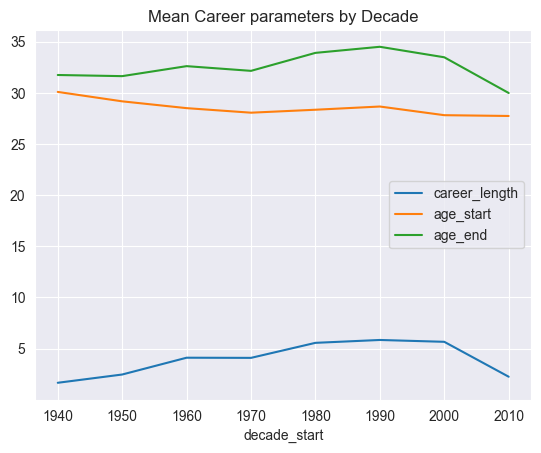

In [38]:
career_parameters_changes = players_data.groupby("decade_start").aggregate(
    {"career_length": "mean", "age_start": "mean", "age_end": "mean"}
)
career_parameters_changes.plot(kind="line")
plt.title("Mean Career parameters by Decade")
plt.show()

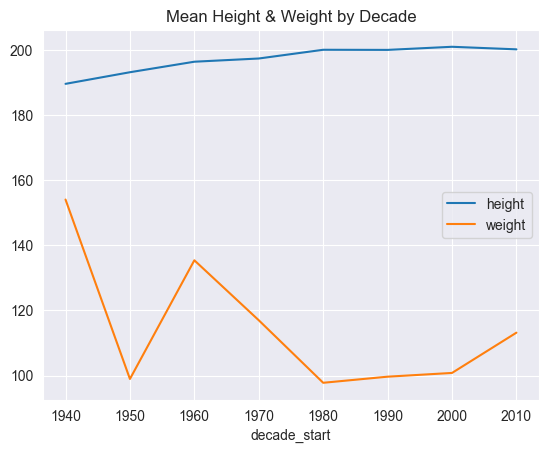

In [39]:
players_data.groupby("decade_start").aggregate({"height": "mean", "weight": "mean"}).plot(kind="line")
plt.title("Mean Height & Weight by Decade")
plt.show()

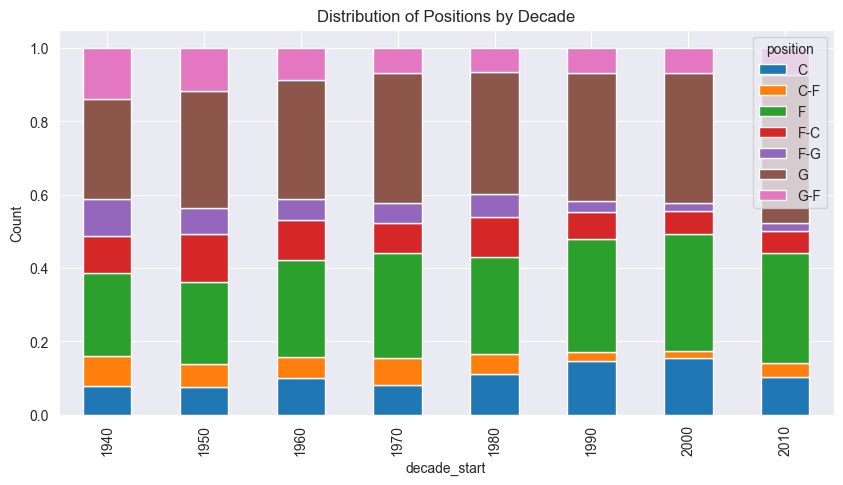

In [40]:
position_counts = players_data.groupby(["decade_start", "position"]).size().unstack()
position_counts = position_counts.div(position_counts.sum(axis=1), axis=0)

position_counts.plot(kind="bar", stacked=True, figsize=(10, 5))
plt.ylabel("Count")
plt.title("Distribution of Positions by Decade")
plt.show()

/var/folders/5m/vtkls86x2_n4srmnn0xjgxs40000gn/T/ipykernel_22549/1747694673.py:8: FutureWarning:

In a future version of pandas all arguments of DataFrame.pivot will be keyword-only.



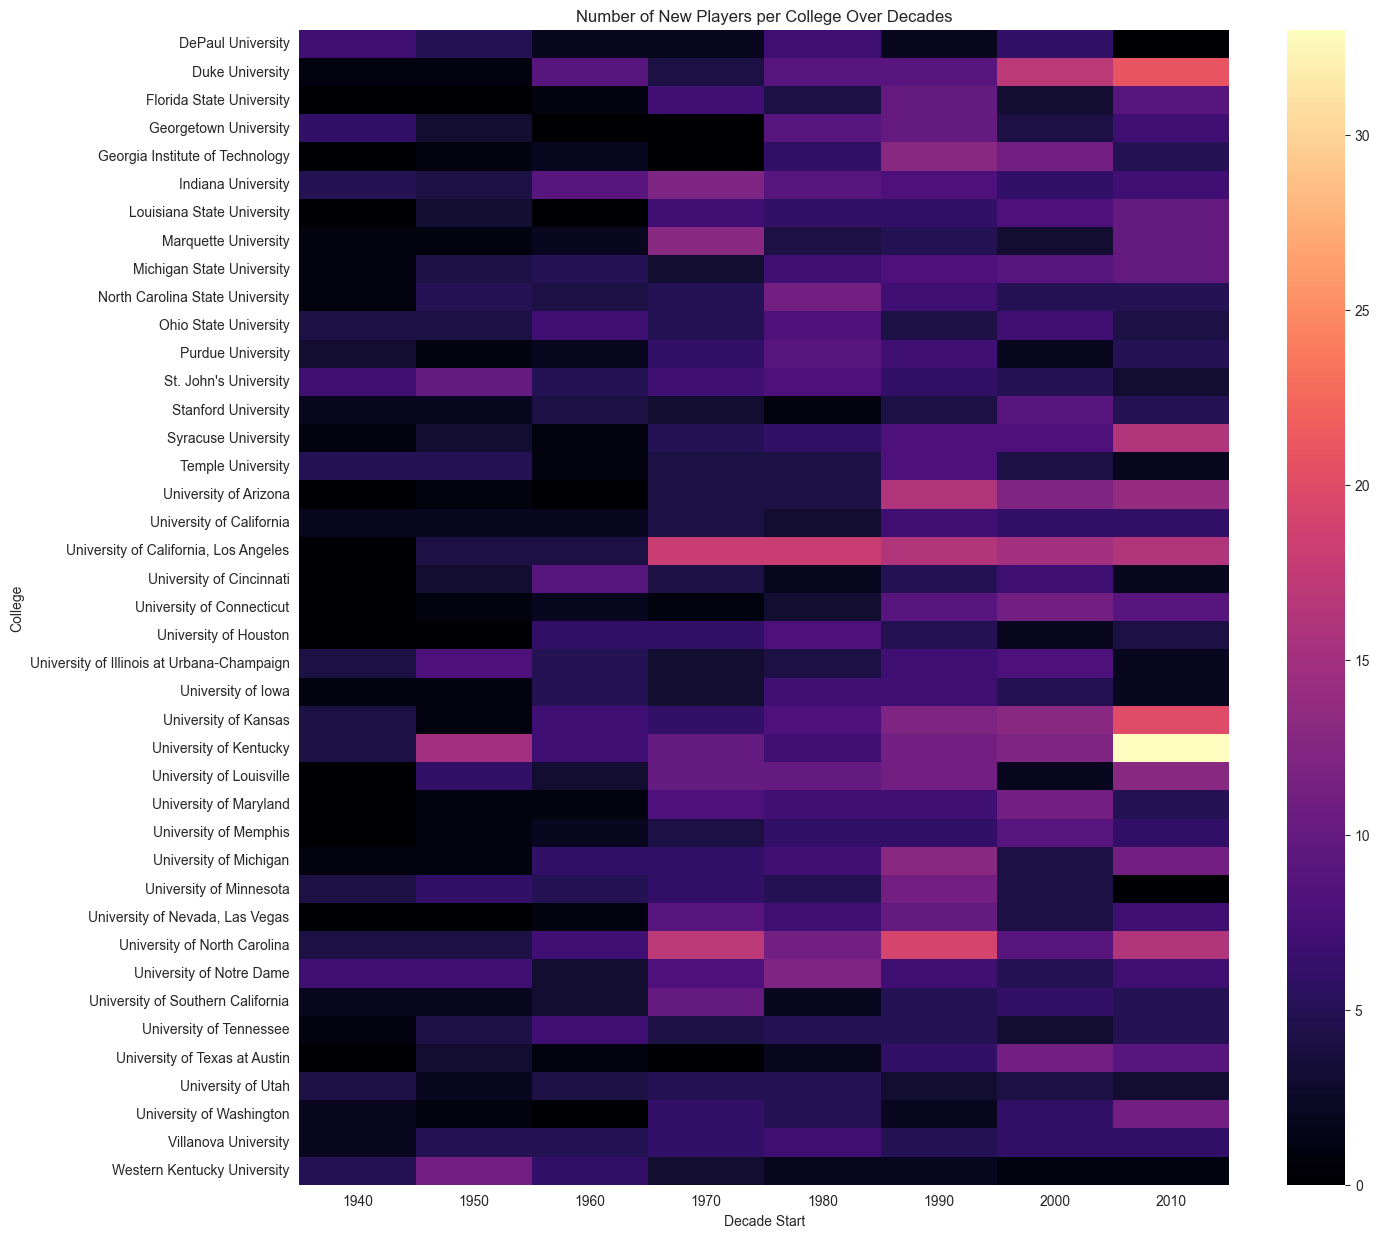

In [41]:
valuable_colleges = players_data.groupby("college").size() >= 30
valuable_colleges_names = valuable_colleges[valuable_colleges].index
colleges_popularity = players_data[players_data["college"].isin(valuable_colleges_names)]

colleges_popularity = colleges_popularity.groupby(["decade_start", "college"]).size().reset_index()
colleges_popularity.columns = ["decade_start", "college", "num_players"]

data_pivot = colleges_popularity.pivot("college", "decade_start", "num_players")
data_pivot = data_pivot.fillna(0)

plt.figure(figsize=(15, 15))
sns.heatmap(data_pivot, cmap="magma")
plt.title("Number of New Players per College Over Decades")
plt.xlabel("Decade Start")
plt.ylabel("College")
plt.show()

/var/folders/5m/vtkls86x2_n4srmnn0xjgxs40000gn/T/ipykernel_22549/1870371493.py:8: FutureWarning:

In a future version of pandas all arguments of DataFrame.pivot will be keyword-only.



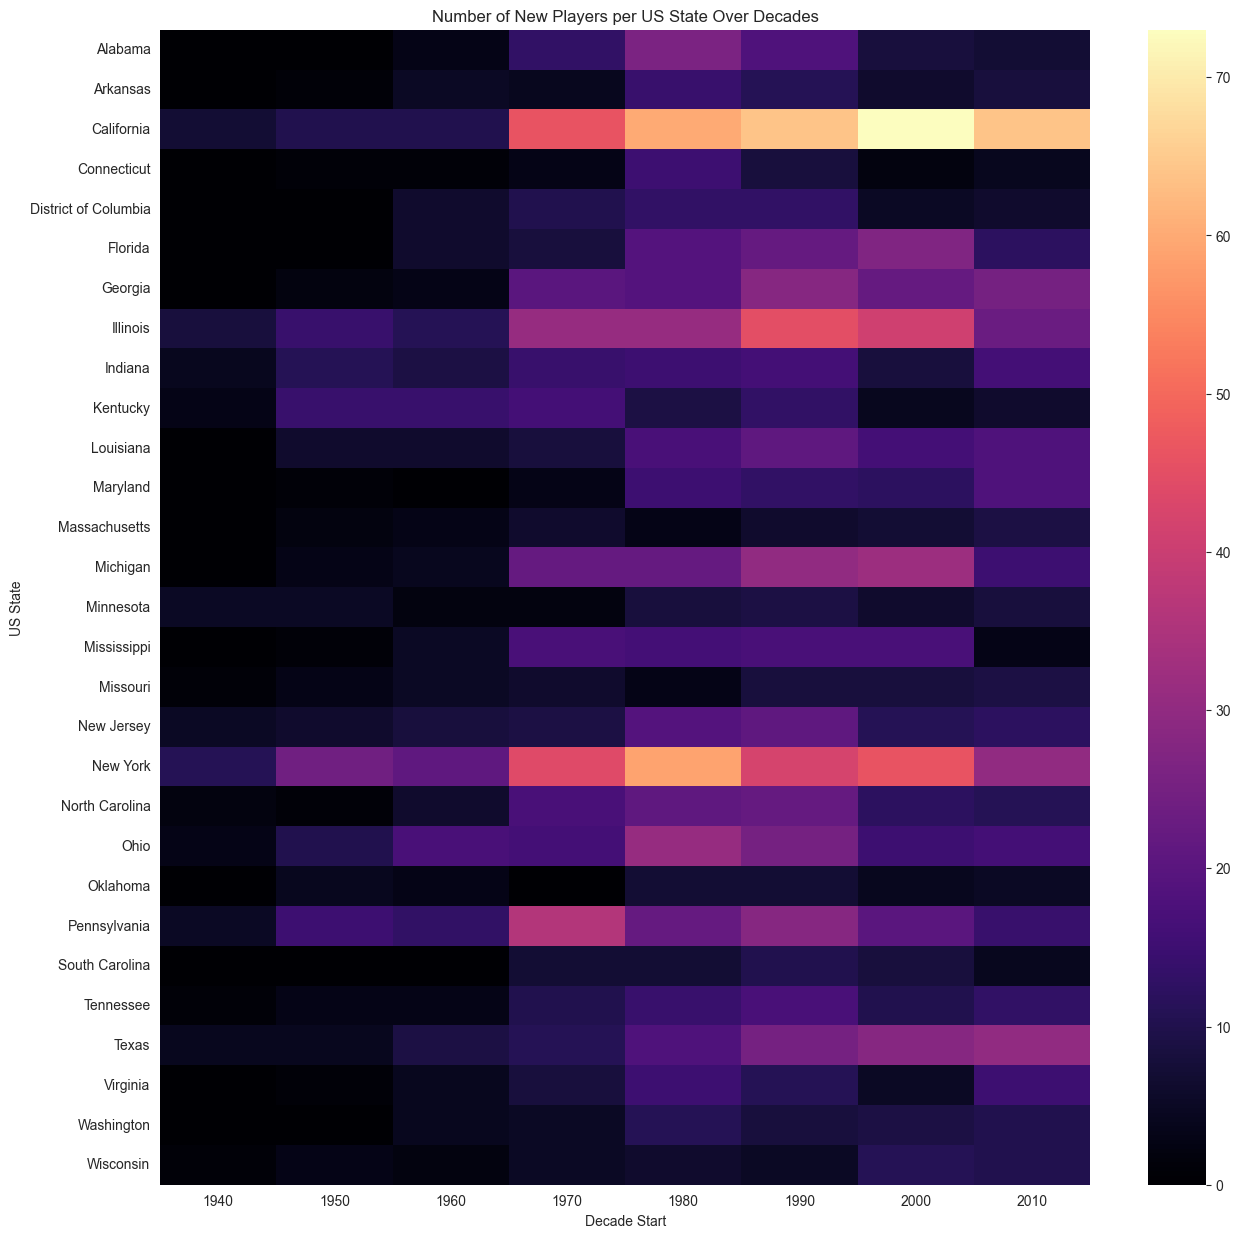

In [42]:
players_with_state = players_data[players_data["birth_state"].notna()]
valuable_states = players_with_state.groupby("birth_state").size() >= 30
valuable_states_names = valuable_states[valuable_states].index
states_popularity = players_data[players_data["birth_state"].isin(valuable_states_names)]
states_popularity = states_popularity.groupby(["decade_start", "birth_state"]).size().reset_index()
states_popularity.columns = ["decade_start", "birth_state", "num_players"]

data_pivot = states_popularity.pivot("birth_state", "decade_start", "num_players")
data_pivot = data_pivot.fillna(0)

plt.figure(figsize=(15, 15))
sns.heatmap(data_pivot, cmap="magma")
plt.title("Number of New Players per US State Over Decades")
plt.xlabel("Decade Start")
plt.ylabel("US State")
plt.show()

## Players Statistics

In [43]:
player_stats = pd.read_csv("../datasets/visualisation_hw/Seasons_Stats.csv")

In [44]:
player_stats.head()

,Unnamed: 0,Year,Player,Pos,Age,Tm,G,GS,MP,PER,...,FT%,ORB,DRB,TRB,AST,STL,BLK,TOV,PF,PTS
0,0,1950.0,Curly Armstrong,G-F,31.0,FTW,63.0,NaN,NaN,NaN,...,0.705,NaN,NaN,NaN,176.0,NaN,NaN,NaN,217.0,458.0
1,1,1950.0,Cliff Barker,SG,29.0,INO,49.0,NaN,NaN,NaN,...,0.708,NaN,NaN,NaN,109.0,NaN,NaN,NaN,99.0,279.0
2,2,1950.0,Leo Barnhorst,SF,25.0,CHS,67.0,NaN,NaN,NaN,...,0.698,NaN,NaN,NaN,140.0,NaN,NaN,NaN,192.0,438.0
3,3,1950.0,Ed Bartels,F,24.0,TOT,15.0,NaN,NaN,NaN,...,0.559,NaN,NaN,NaN,20.0,NaN,NaN,NaN,29.0,63.0
4,4,1950.0,Ed Bartels,F,24.0,DNN,13.0,NaN,NaN,NaN,...,0.548,NaN,NaN,NaN,20.0,NaN,NaN,NaN,27.0,59.0


In [45]:
player_stats.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24691 entries, 0 to 24690
Data columns (total 53 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Unnamed: 0  24691 non-null  int64  
 1   Year        24624 non-null  float64
 2   Player      24624 non-null  object 
 3   Pos         24624 non-null  object 
 4   Age         24616 non-null  float64
 5   Tm          24624 non-null  object 
 6   G           24624 non-null  float64
 7   GS          18233 non-null  float64
 8   MP          24138 non-null  float64
 9   PER         24101 non-null  float64
 10  TS%         24538 non-null  float64
 11  3PAr        18839 non-null  float64
 12  FTr         24525 non-null  float64
 13  ORB%        20792 non-null  float64
 14  DRB%        20792 non-null  float64
 15  TRB%        21571 non-null  float64
 16  AST%        22555 non-null  float64
 17  STL%        20792 non-null  float64
 18  BLK%        20792 non-null  float64
 19  TOV%        19582 non-nul

In [46]:
player_stats.drop(["Unnamed: 0", "blanl", "blank2"], axis=1, inplace=True)

In [47]:
mean_per_player = player_stats.groupby("Player", as_index=False).aggregate("mean")

/var/folders/5m/vtkls86x2_n4srmnn0xjgxs40000gn/T/ipykernel_22549/3526996382.py:1: FutureWarning:

The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.



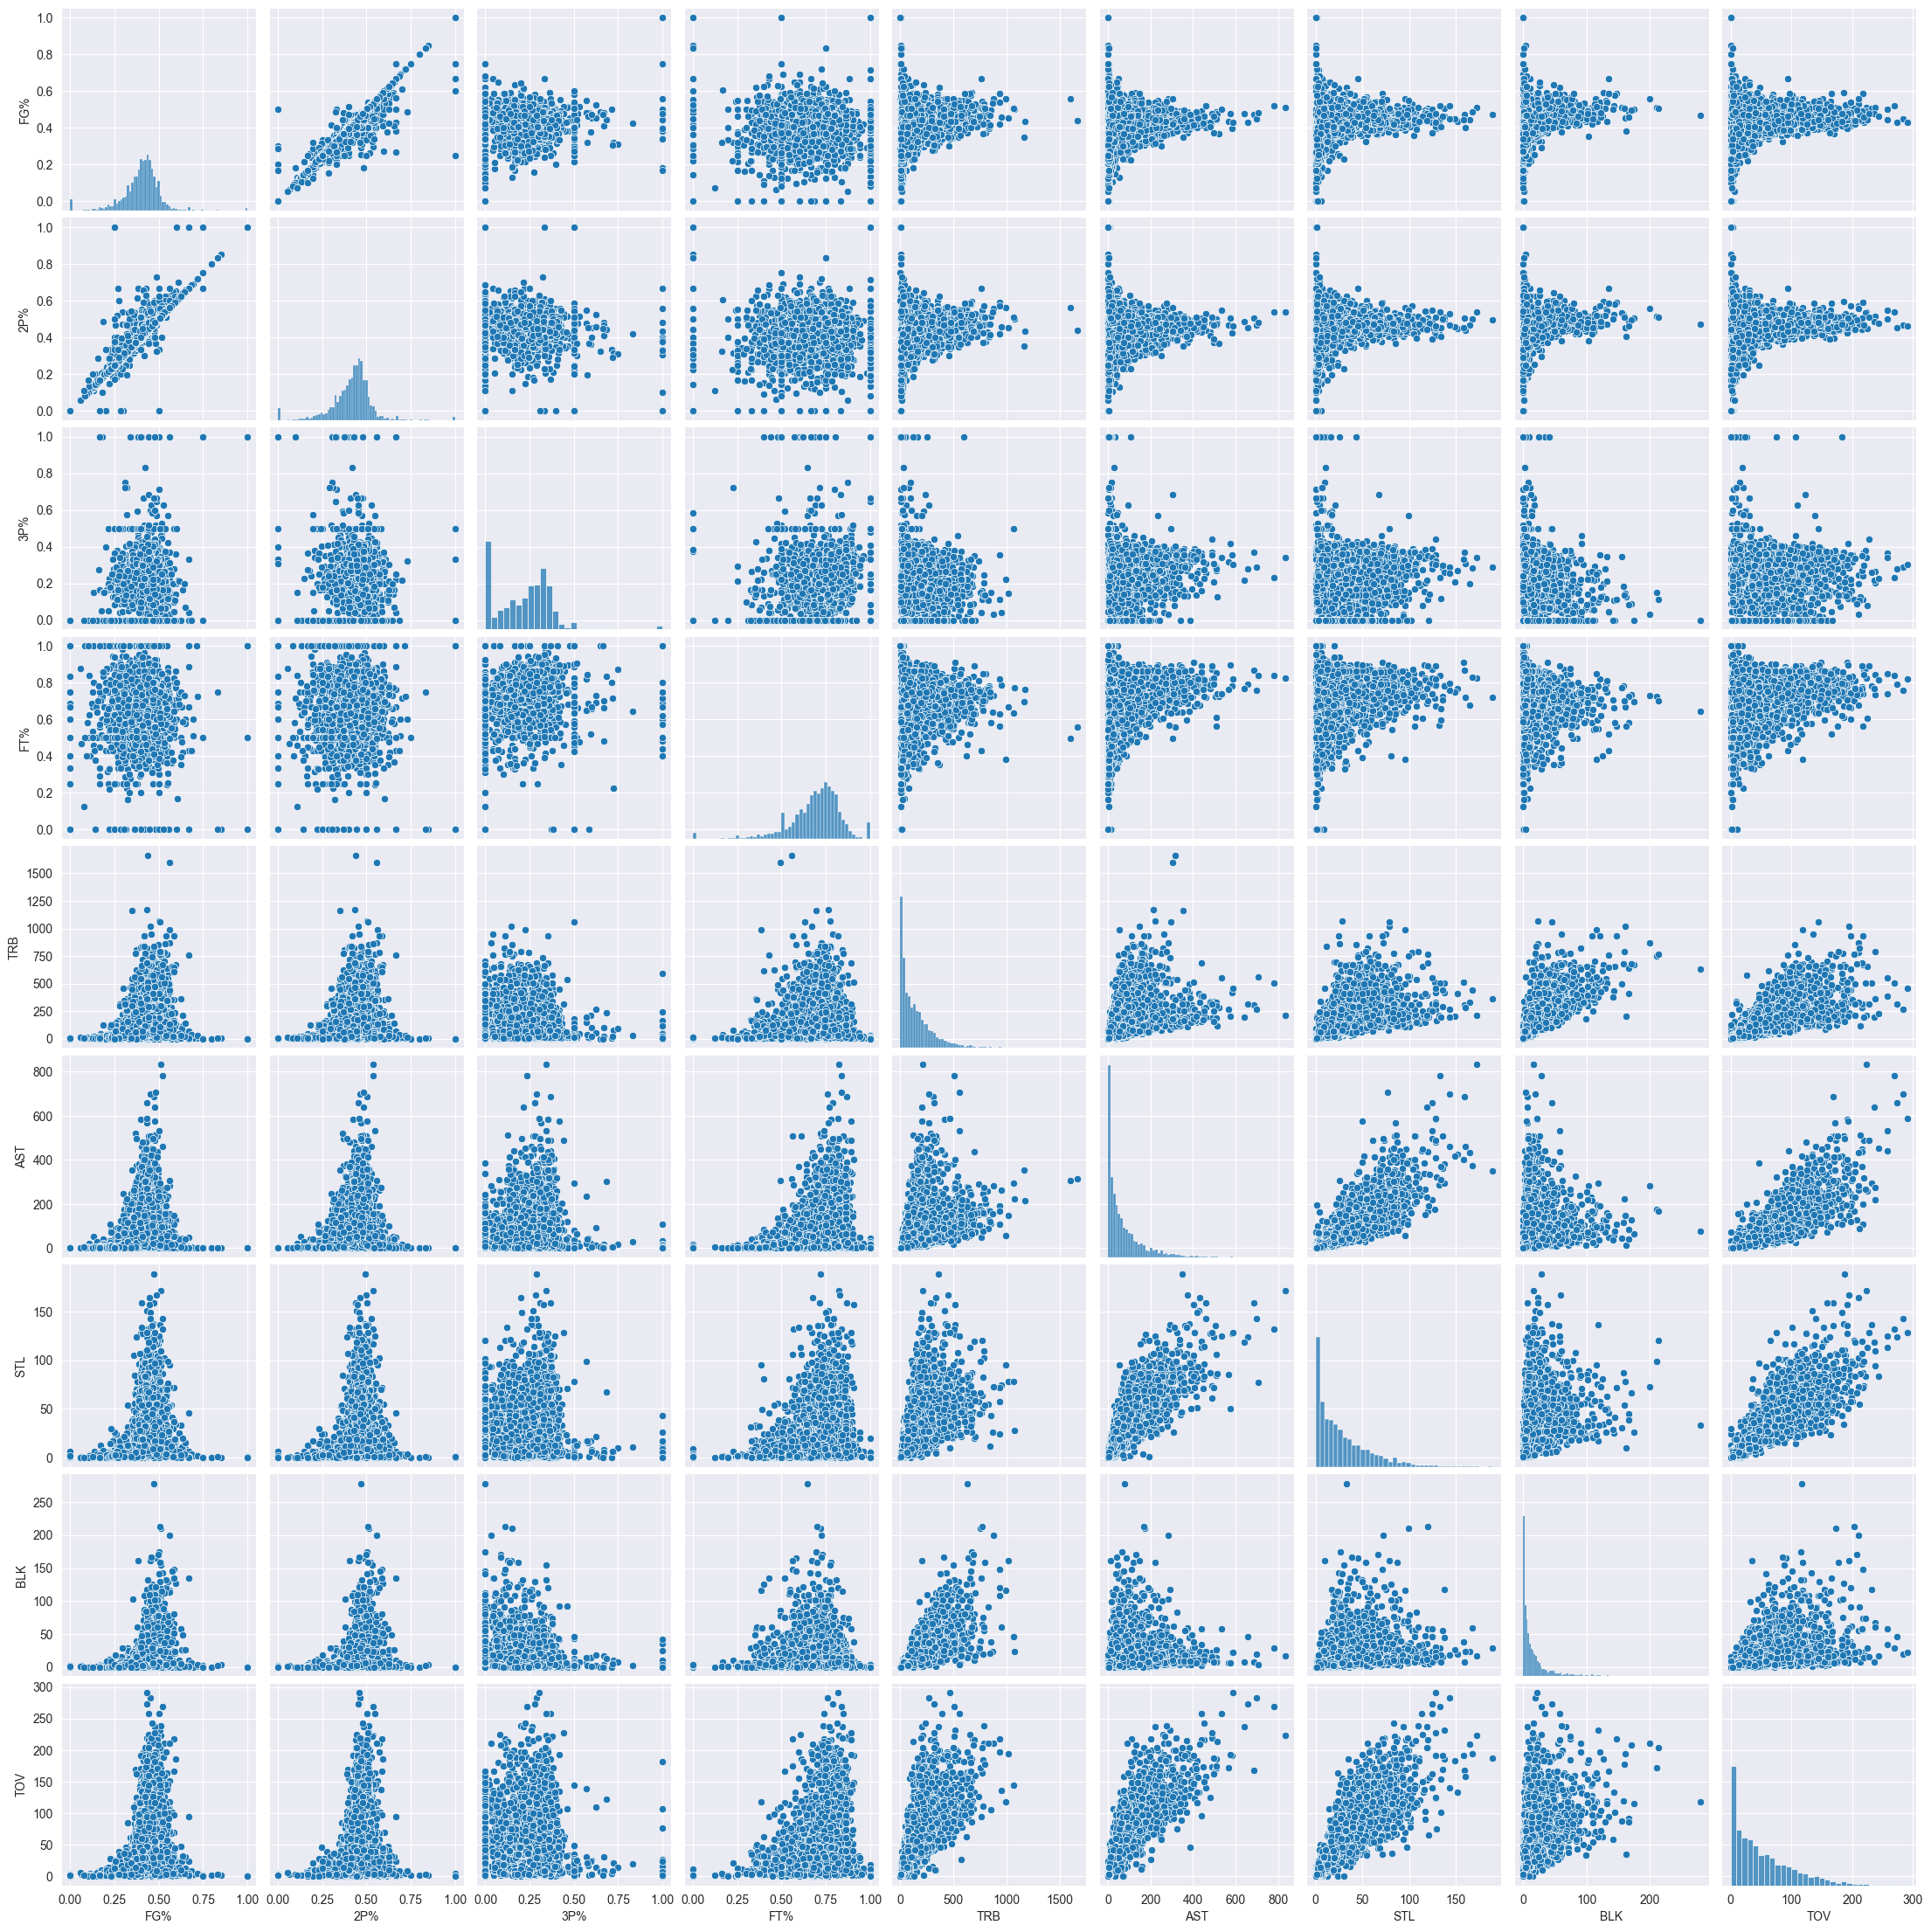

In [48]:
sns.pairplot(mean_per_player[["FG%", "2P%", "3P%", "FT%", "TRB", "AST", "STL", "BLK", "TOV"]])

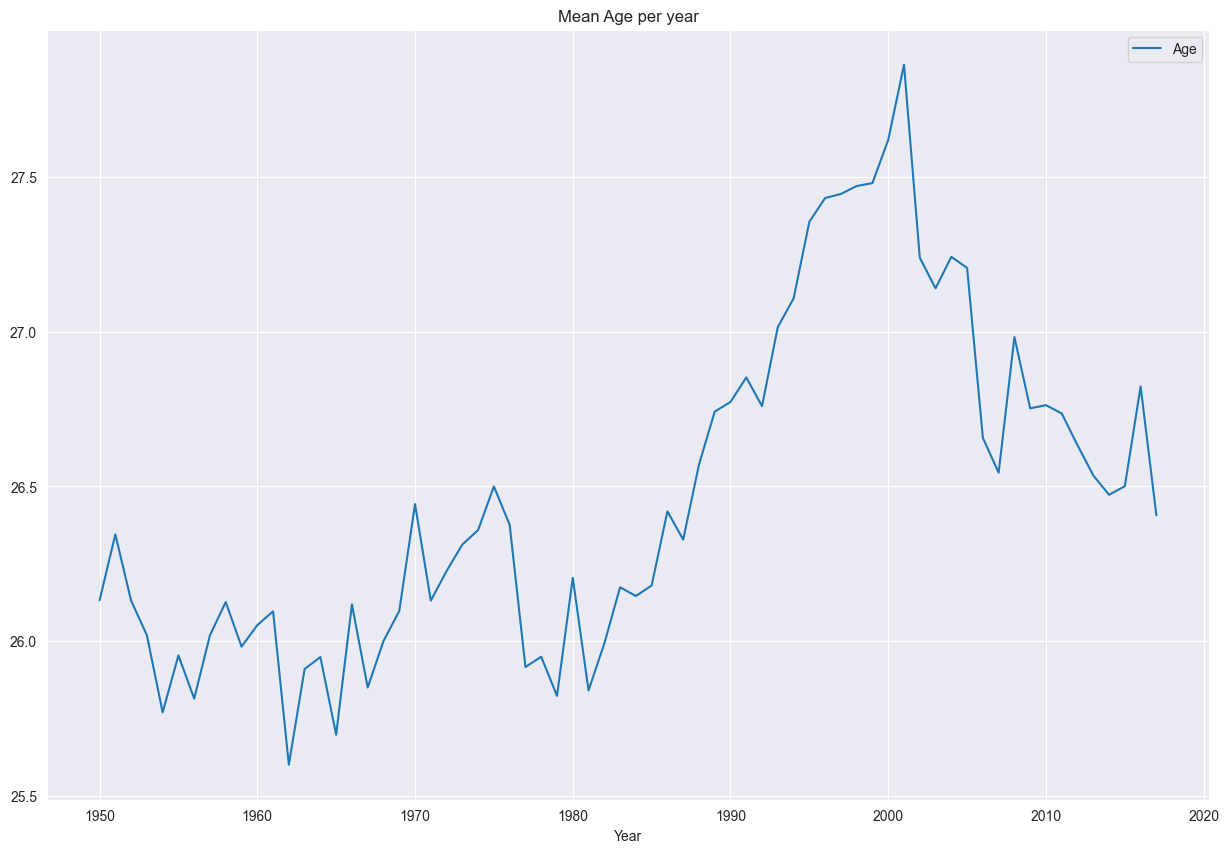

In [49]:
stats_by_year = player_stats.groupby("Year")
stats_by_year.aggregate({"Age": "mean"}).plot(kind="line", figsize=(15, 10))
plt.title("Mean Age per year")
plt.show()

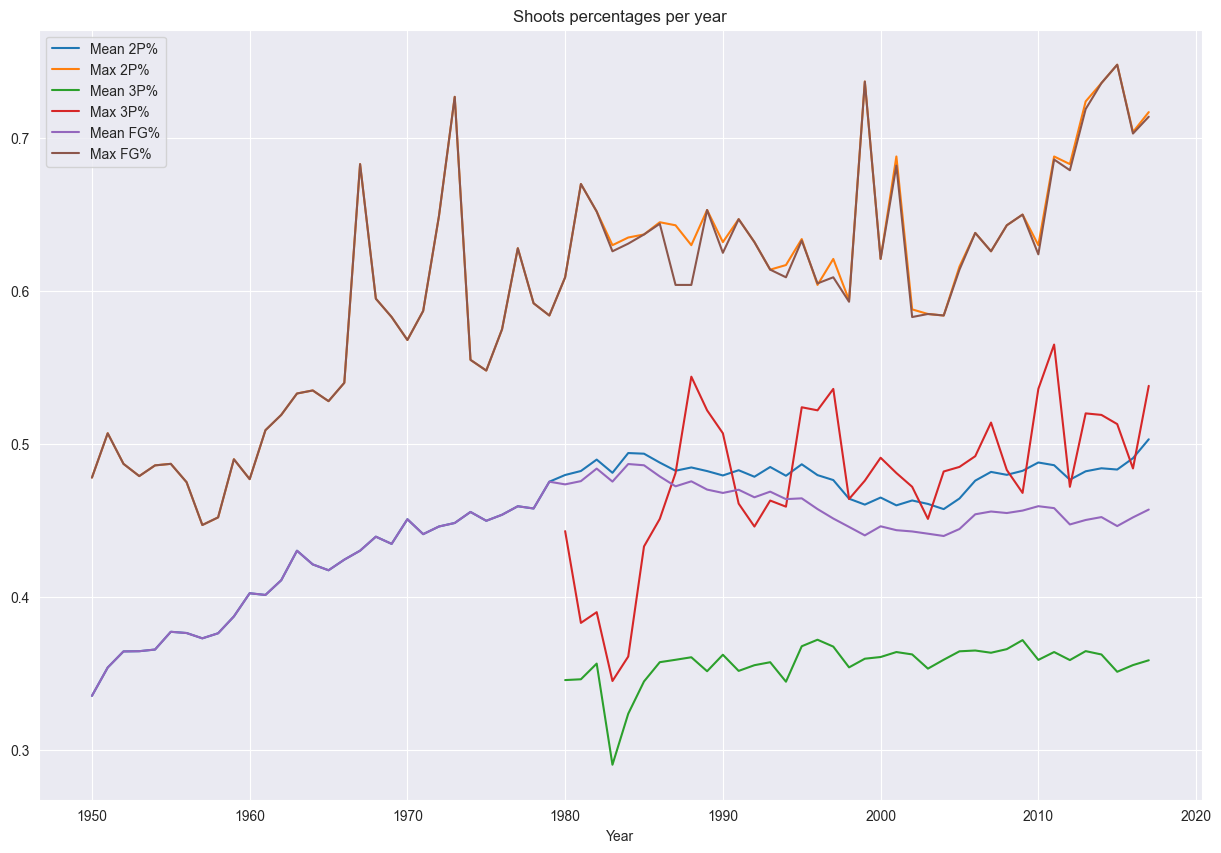

In [50]:
shoot_stats = pd.DataFrame(index=pd.Index([], name="Year"))
for shoot_type, shoot_count_threshold in (("2P", 50), ("3P", 25), ("FG", 50)):
    shoot_type_percent = f"{shoot_type}%"
    filtered_stats = player_stats[player_stats[shoot_type] > shoot_count_threshold]
    aggregated_stats = filtered_stats.groupby("Year")[shoot_type_percent].aggregate(["mean", "max"])
    aggregated_stats.rename(
        columns={"mean": f"Mean {shoot_type_percent}", "max": f"Max {shoot_type_percent}"}, inplace=True
    )
    shoot_stats = shoot_stats.merge(aggregated_stats, on="Year", how="outer")

shoot_stats.plot(kind="line", figsize=(15, 10))
plt.title(f"Shoots percentages per year")
plt.show()

In [51]:
player_stats["generalized_position"] = player_stats["Pos"][player_stats["Pos"].notna()].apply(lambda x: x.split("-")[0])
player_stats["generalized_position"][player_stats["generalized_position"].isin(["F", "G"])].count() / player_stats[
    "generalized_position"
].count()

0.01957439896036387

In [52]:
player_stats = player_stats[
    (~player_stats["generalized_position"].isin(["F", "G"])) & (player_stats["generalized_position"].notna())
]

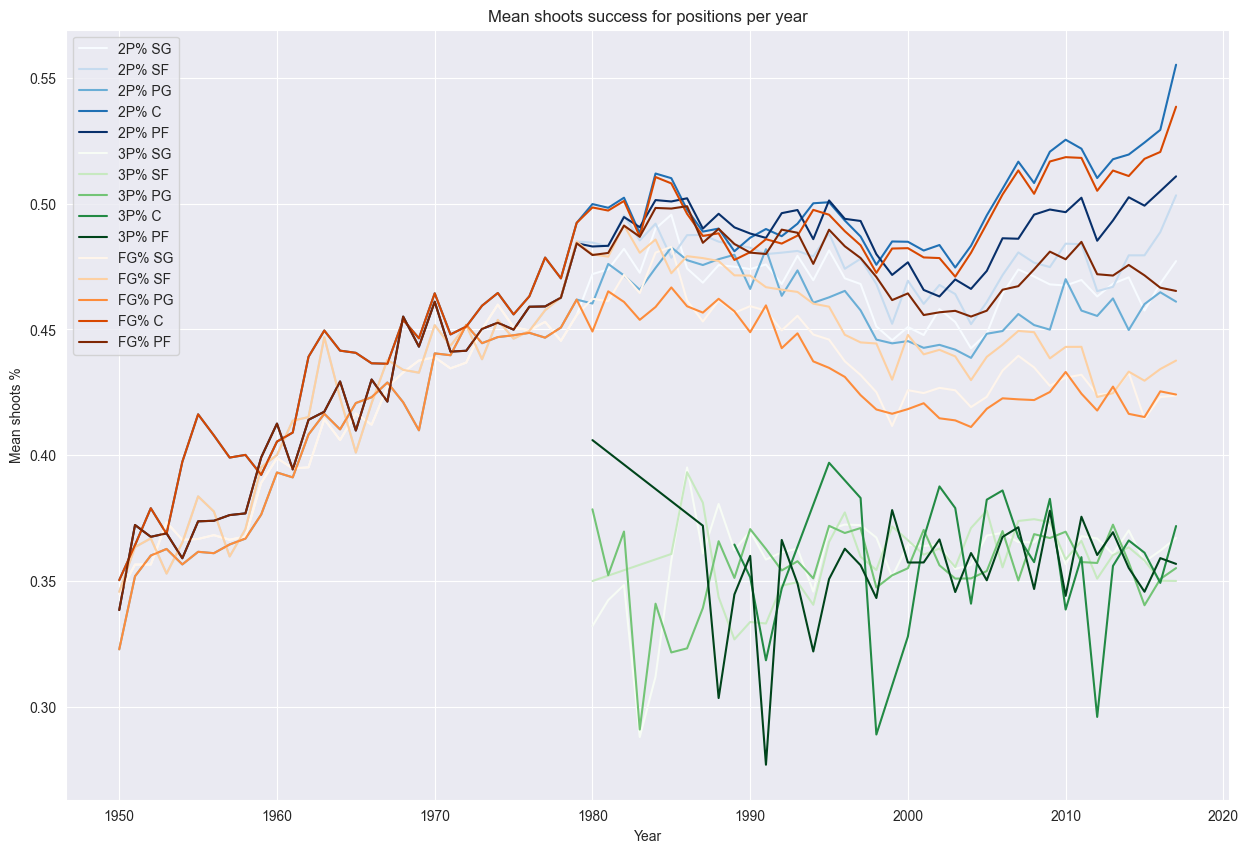

In [53]:
clear_positions = player_stats["generalized_position"].unique()
plt.figure(figsize=(15, 10))
for shoot_type, shoot_count_threshold, color_map in (
    ("2P", 50, cm.Blues),
    ("3P", 25, cm.Greens),
    ("FG", 50, cm.Oranges),
):
    filtered_stats = player_stats[player_stats[shoot_type] > shoot_count_threshold]
    aggregated_stats = filtered_stats.groupby(["Year", "Pos"])[f"{shoot_type}%"].aggregate("mean").reset_index()

    colors = color_map(np.linspace(0, 1, len(clear_positions)))
    for i, pos in enumerate(clear_positions):
        data_subset = aggregated_stats[aggregated_stats["Pos"] == pos]
        plt.plot(data_subset["Year"], data_subset[f"{shoot_type}%"], label=f"{shoot_type}% {pos}", color=colors[i])

plt.title("Mean shoots success for positions per year")
plt.xlabel("Year")
plt.ylabel(f"Mean shoots %")
plt.legend()
plt.show()

###  And let's make it interactive a little

In [55]:
import plotly.graph_objects as go

shoot_types = ["2P", "3P", "FG"]
positions = player_stats["generalized_position"].unique()

fig = go.Figure()

for shoot_type in shoot_types:
    for position in positions:
        df = player_stats[(player_stats[shoot_type] > 50) & (player_stats["Pos"] == position)]
        df = df.groupby("Year")[f"{shoot_type}%"].mean().reset_index()
        fig.add_trace(
            go.Scatter(
                x=df["Year"],
                y=df[f"{shoot_type}%"],
                mode="lines",
                name=f"{shoot_type}% {position}",
                visible="legendonly",
            )
        )

dropdown_menus = [
    {
        "buttons": [
            {
                "label": shoot_type,
                "method": "update",
                "args": [{"visible": [(fig.data[i].name.split("% ")[0] == shoot_type) for i in range(len(fig.data))]}],
            }
            for shoot_type in shoot_types
        ],
        "direction": "down",
        "showactive": True,
        "x": 0.1,
        "y": 1.2,
    },
    {
        "buttons": [
            {
                "label": position,
                "method": "update",
                "args": [{"visible": [(fig.data[i].name.split("% ")[1] == position) for i in range(len(fig.data))]}],
            }
            for position in positions
        ],
        "direction": "down",
        "showactive": True,
        "x": 0.4,
        "y": 1.2,
    },
]

fig.update_layout(
    updatemenus=dropdown_menus,
    title="Mean shoots success for positions per year",
    xaxis_title="Year",
    yaxis_title="Mean shoots %",
)

fig.show()

In [50]:
player_stats.rename(columns={"Player": "name"}, inplace=True)
player_stats = player_stats.merge(players_data, on="name", how="left")

/var/folders/5m/vtkls86x2_n4srmnn0xjgxs40000gn/T/ipykernel_24969/1823188397.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_stats.rename(columns={"Player": "name"}, inplace=True)


In [59]:
player_stats[player_stats.G > 20]

,Year,name,Pos,Age,Tm,G,GS,MP,PER,TS%,...,birth_state,height,weight,career_length,birth_year,birth_decade,decade_start,decade_end,age_start,age_end
0,1950.0,Cliff Barker,SG,29.0,INO,49.0,NaN,NaN,NaN,0.435,...,Indiana,188.0,83.0,2.0,1920.0,1920.0,1950.0,1950.0,30.0,32.0
1,1950.0,Leo Barnhorst,SF,25.0,CHS,67.0,NaN,NaN,NaN,0.394,...,NaN,193.0,86.0,4.0,1920.0,1920.0,1950.0,1950.0,30.0,34.0
2,1950.0,Nelson Bobb,PG,25.0,PHW,57.0,NaN,NaN,NaN,0.396,...,Pennsylvania,183.0,77.0,3.0,1920.0,1920.0,1950.0,1950.0,30.0,33.0
3,1950.0,Vince Boryla,SF,22.0,NYK,59.0,NaN,NaN,NaN,0.426,...,Indiana,196.0,95.0,4.0,1920.0,1920.0,1950.0,1950.0,30.0,34.0
4,1950.0,Harry Boykoff,C,27.0,WAT,61.0,NaN,NaN,NaN,0.479,...,New York,208.0,102.0,1.0,1920.0,1920.0,1950.0,1950.0,30.0,31.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24735,2017.0,Thaddeus Young,PF,28.0,IND,74.0,74.0,2237.0,14.9,0.562,...,Louisiana,203.0,100.0,10.0,1980.0,1980.0,2000.0,2010.0,28.0,38.0
24736,2017.0,Cody Zeller,PF,24.0,CHO,62.0,58.0,1725.0,16.7,0.604,...,Indiana,213.0,108.0,4.0,1990.0,1990.0,2010.0,2010.0,24.0,28.0
24737,2017.0,Tyler Zeller,C,27.0,BOS,51.0,5.0,525.0,13.0,0.508,...,California,213.0,114.0,5.0,1990.0,1990.0,2010.0,2010.0,23.0,28.0
24739,2017.0,Paul Zipser,SF,22.0,CHI,44.0,18.0,843.0,6.9,0.503,...,Germany,203.0,97.0,1.0,1990.0,1990.0,2010.0,2010.0,27.0,28.0


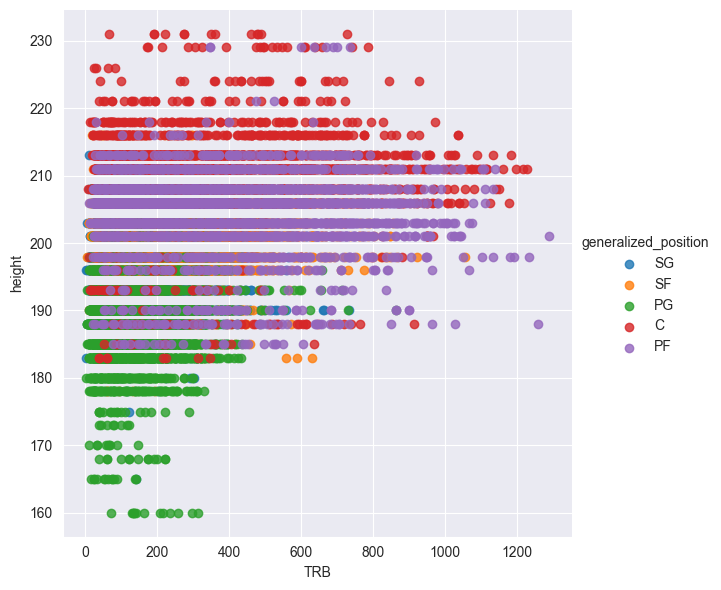

In [76]:
sns.lmplot(
    x="TRB", y="height", data=player_stats[player_stats.G > 20], hue="generalized_position", fit_reg=False, height=6
);

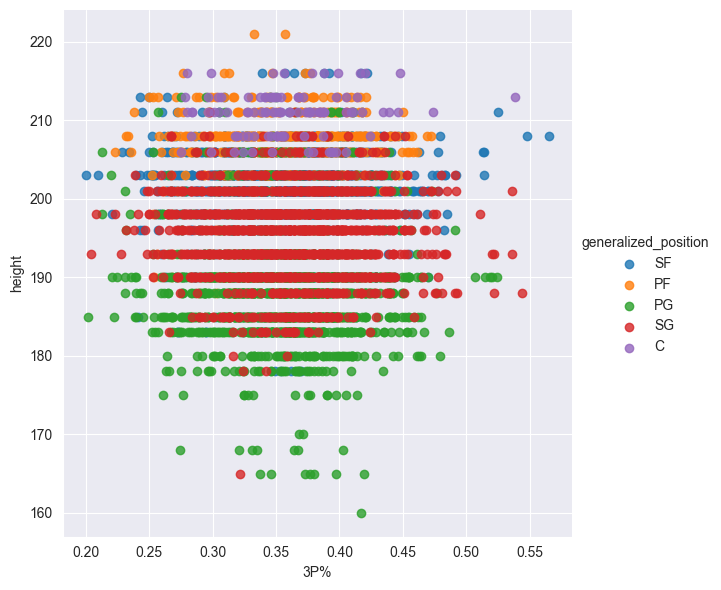

In [74]:
sns.lmplot(
    x="3P%",
    y="height",
    data=player_stats[(player_stats.G > 20) & (player_stats["3P"] > 20)],
    hue="generalized_position",
    fit_reg=False,
    height=6,
);